In [1]:
import pickle
import time
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

cur_dir = os.getcwd()
main_dir = os.path.dirname(os.path.dirname(cur_dir))

# Investigate the PZT data

In [ ]:
data_dir = os.path.join(main_dir, "ConsolidatedData")
filename = "consolidated_pzt_Day1_Training1.pkl"
file_path = os.path.join(data_dir, filename)
with open(os.path.join(file_path),'rb') as f:
  data = pickle.load(f)

# data = pd.read_csv(file_path, header=0)

In [ ]:
import matplotlib.pyplot as plt
pzt_data = data
last_phase_pzt1 = pzt_data.iloc[144000000:144000000+11280000]["PZT 1"]
plt.plot(last_phase_pzt1)
plt.show()

# Investigate the SG/RTD Data

## Examine the SG/RTD Data

In [6]:
data_dir = os.path.join(main_dir, "ConsolidatedData")
with open(os.path.join(data_dir,'videotimed_labeled_consolidated_all.pkl'), 'rb') as f:
  training_df = pickle.load(f)

In [ ]:
#Experiments to shed light on the time delta between RTD&SG and PZTs
#Check for big time jumps in SG/RTD timestamps that we cannot explain.

#Load the data
with open(os.path.join(data_dir,'videotimed_labeled_consolidated_all.pkl'), 'rb') as f:
  training_df = pickle.load(f)
cur_dir = os.getcwd()
main_dir = os.path.dirname(os.path.dirname(cur_dir))
test_date = "08_02_2022"
test_folder = "Day2_Training1"
rtdstr_filename = "compensated_normalized_WTRUN2_day2_training1_2022-08-02_12-38-30-01_rtd-str.csv"
data_dir = os.path.join(main_dir, test_date+"_Tests", "testdata", test_folder)
file_csv = os.path.join(data_dir, rtdstr_filename)
training_df = pd.read_csv(file_csv, header=0)

rtdstr_times = training_df["Date/Time"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d_%H-%M-%S-%f"))
rtdstr_times = rtdstr_times.apply(lambda x: datetime.datetime(1900, 1, 1, x.hour, x.minute, x.second, x.microsecond)) #We do this because we haven't recorded date in the original data.
training_df.insert(1, "rtdstr_DateTime Obj", rtdstr_times)


#Look at the time passed at each test run in RTD/SG data.
t1 = training_df["rtdstr_DateTime Obj"].iloc[1964089] - training_df["rtdstr_DateTime Obj"].iloc[0]
t2 = training_df["rtdstr_DateTime Obj"].iloc[-1] - training_df["rtdstr_DateTime Obj"].iloc[1964090]
time = t1+t2
time_seconds = t1.total_seconds()
print (time_seconds)

#See if there's any big time jump that we cannot quite explain.
training_df.insert(2, "Time Diff", None)
training_df['shifted_rtdstr_DateTime Obj'] = training_df['rtdstr_DateTime Obj'].shift(-1)
training_df["Time Diff"] = training_df["shifted_rtdstr_DateTime Obj"] - training_df["rtdstr_DateTime Obj"]
training_df[training_df["Time Diff"] > datetime.timedelta(0,0,100000)]

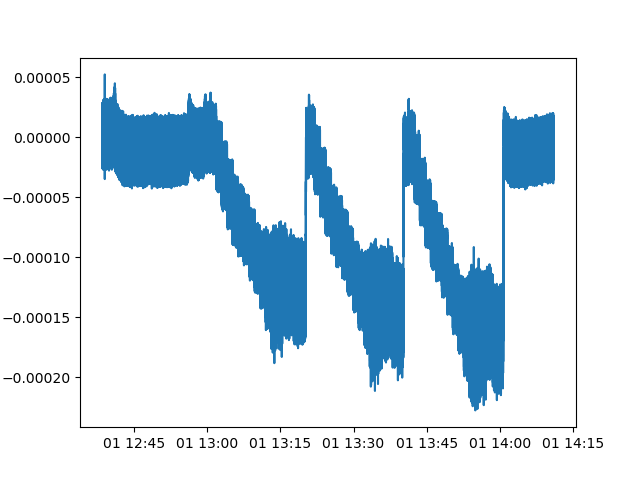

In [7]:
%matplotlib widget
with open(os.path.join(data_dir,'repeated_sg_1.pkl'), 'rb') as f:
  sg_df = pickle.load(f)

plt.plot(sg_df["repeated_DateTime Obj"], sg_df["SG 1 (V) (normalized) (compensated)"])



# Investigate Training Data

## Investigate the concatenated data from multiple dfs

In [ ]:
data_dir = os.path.join(main_dir, "KerasTraining", "Training1", "data")
multidf_data = np.load(os.path.join(data_dir, "sttr_aug2022_data_multidf.npy"))
state_labels = np.load(os.path.join(data_dir, "sttr_aug2022_statelabels.npy"))
stackedAllExamples_multidf = np.transpose(multidf_data, (1,0,2)).reshape(14, -1)

# Here data.shape = (#of states, #of sensors, #data per each state) (238, 14, 599200 for Aug. 2022 test)
# states: 7m/s_0deg, 7m/s_1deg, ... 20m/s_15deg, 20m/s_16deg.
# sensors: ['PZT 1', 'PZT 2', 'PZT 3', 'PZT 4', 'PZT 5', 'PZT 6', 'PZT 7', 'SG 1', 'SG 2', 'SG 4', 'SG 5', 'SG 6', 'SG LE', 'SG TE']
# data: 10,000sps * ~60 seconds 


In [ ]:
# Plot the SG evolution over all airspeeds and aoas
fig, ax = plt.subplots()
ax.plot(stackedAllExamples_multidf[8][:]) #SG 1

In [ ]:
# Plot the PZT response to observe the desync from SG/RTD.
# Best indicator is 10deg to 11deg where stall initiates
# (17m/s_10deg)(ix: 180) should happen in both
# (18m/s_10deg)(ix: 197) should happen only in singledf (because of improper concatenation)

fig, ax = plt.subplots(1)

ax.plot(stackedAllExamples_multidf[7, int(180*599200) : int(181*599200)], linewidth=0.3) #18m/s_10deg - PZT 1
ax.set_xlim(480000, 560000)
# ax.plot(stackedAllExamples_multidf[0, int(197*599200) : int(198*599200)], linewidth=0.3) #18m/s_10deg - PZT 1
# ax.set_xlim(480000, 560000)
# ax[1].plot(stackedAllExamples_multidf[7, int(197*599200) : int(198*599200)], linewidth=0.3) #18m/s_10deg - SG 1
# ax[1].set_xlim(480000, 560000)

## Investigate the concatenated data from single df (main data)

In [10]:
data_dir = os.path.join(main_dir, "KerasTraining", "Training1", "data")
singledf_data = np.load(os.path.join(data_dir, "sttr_aug2022_data_singledf.npy"))
state_labels = np.load(os.path.join(data_dir, "sttr_aug2022_statelabels.npy"))
stackedAllExamples_singledf = np.transpose(singledf_data, (1,0,2)).reshape(14, -1)

# Here data.shape = (#of states, #of sensors, #data per each state) (238, 14, 599200 for Aug. 2022 test)
# states: 7m/s_0deg, 7m/s_1deg, ... 20m/s_15deg, 20m/s_16deg.
# sensors: ['PZT 1', 'PZT 2', 'PZT 3', 'PZT 4', 'PZT 5', 'PZT 6', 'PZT 7', 'SG 1', 'SG 2', 'SG 4', 'SG 5', 'SG 6', 'SG LE', 'SG TE']
# data: 10,000sps * ~60 seconds 

In [7]:
print (singledf_data.shape)
print (stackedAllExamples_singledf.shape)

(238, 14, 599200)
(14, 142609600)


Text(0.5, 0, 'Time (sec)')

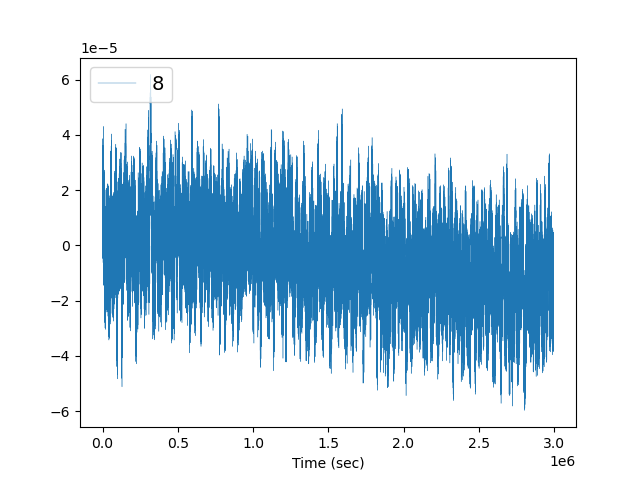

In [9]:
fig, ax = plt.subplots(1)
legendkey = list()
for i in [8]:
  ax.plot(stackedAllExamples_singledf[i,0:599200*5], linewidth=0.3)
  legendkey.append(i)
plt.legend(legendkey,loc='upper left', prop={'size':14})
plt.xlabel("Time (sec)")

Text(0.5, 0, 'Time (sec)')

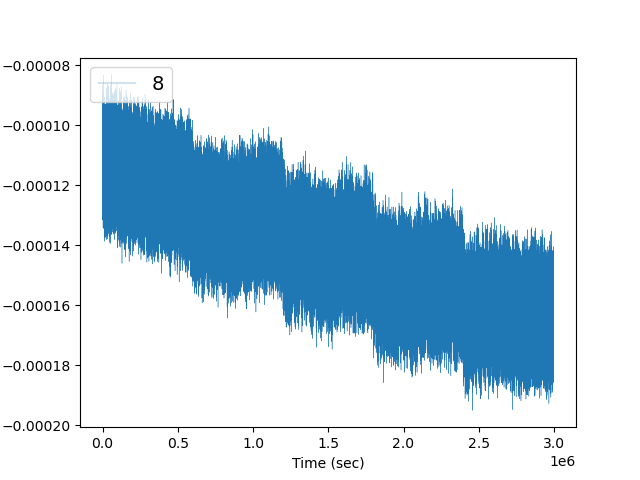

In [12]:
fig, ax = plt.subplots(1)
legendkey = list()
for i in [8]:
  ax.plot(stackedAllExamples_singledf[i,0:599200*5], linewidth=0.3)
  legendkey.append(i)
plt.legend(legendkey,loc='upper left', prop={'size':14})
plt.xlabel("Time (sec)")

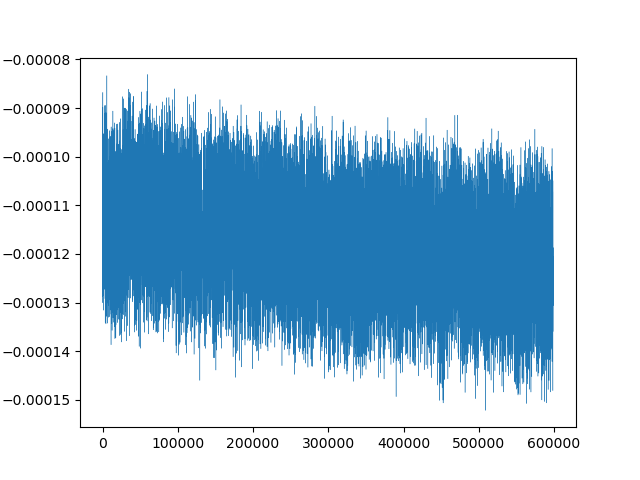

In [3]:
fig, ax = plt.subplots(1)
ax.plot(singledf_data[0:,8,:], linewidth=0.3)

In [15]:
%matplotlib inline

In [ ]:
# Plot the PZT response to observe the desync from SG/RTD.
# Best indicator is 10deg to 11deg where stall initiates
# (17m/s_10deg)(ix: 180) should happen in both
# (18m/s_10deg)(ix: 197) should happen only in singledf (because of improper concatenation)

fig, ax = plt.subplots(1)

# ax.plot(stackedAllExamples_singledf[0, int(213*299600) : int(214*299600)], linewidth=0.3) 
# ax.set_xlim(250000, 299600)
# ax.plot(stackedAllExamples_singledf[0, int(197*599200) : int(198*599200)], linewidth=0.3) 
# ax.set_xlim(480000, 560000)
# ax[1].plot(stackedAllExamples_singledf[7, int(197*599200) : int(198*599200)], linewidth=0.3)
# ax[1].set_xlim(480000, 560000)

## Investigate the concatenated data from single df (backup data)

In [27]:
data_dir = os.path.join(main_dir, "KerasTraining", "Training1_B", "data")
singledf_data_backup = np.load(os.path.join(data_dir, "sttr_aug2022_data_singledf.npy"))
state_labels = np.load(os.path.join(data_dir, "sttr_aug2022_statelabels.npy"))
stackedAllExamples_singledf_frombak = np.transpose(singledf_data_backup, (1,0,2)).reshape(14, -1)

# Here data.shape = (#of states, #of sensors, #data per each state) (238, 14, 599200 for Aug. 2022 test)
# states: 7m/s_0deg, 7m/s_1deg, ... 20m/s_15deg, 20m/s_16deg.
# sensors: ['PZT 1', 'PZT 2', 'PZT 3', 'PZT 4', 'PZT 5', 'PZT 6', 'PZT 7', 'SG 1', 'SG 2', 'SG 4', 'SG 5', 'SG 6', 'SG LE', 'SG TE']
# data: 10,000sps * ~60 seconds 

In [29]:
print (singledf_data_backup.shape)
print (stackedAllExamples_singledf_frombak.shape)

(238, 14, 299600)
(14, 71304800)


Text(0.5, 0, 'Time (sec)')

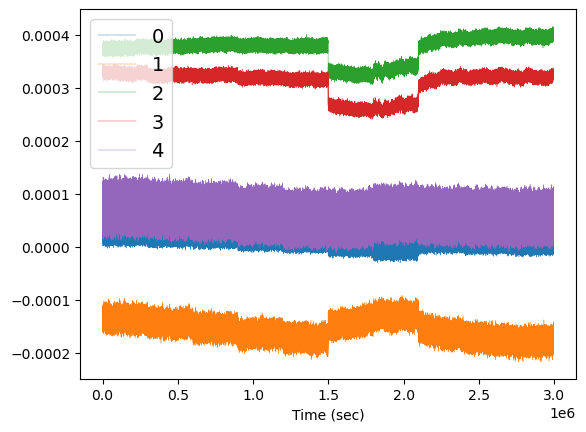

: 

In [41]:
fig, ax = plt.subplots(1)
legendkey = list()
for i in (0,1,2,3,4):
  ax.plot(stackedAllExamples_singledf_frombak[i+7,0:299600*10], linewidth=0.3)
  legendkey.append(i)
plt.legend(legendkey,loc='upper left', prop={'size':14})
plt.xlabel("Time (sec)")

# Misc. Other Investigations

In [7]:
%matplotlib widget

In [1]:
#Investigate time passed between datapoints
import datetime
# t1 = datetime.datetime(1900, 1, 1, 17, 24, 43, 50*10000) #SG/RTD data start of Day1Training1 experiment.
t1 = datetime.datetime(1900, 1, 1, 12, 38, 30, 1*10000) #SG/RTD data start of Day2Training1 experiment. 
# t1 = datetime.datetime(1900, 1, 1, 14, 32, 54, 11*10000) #SG/RTD data start of Day2Dynamic1 experiment. 
# t1 = datetime.datetime(1900, 1, 1, 17, 25, 43, 99*10000) #SG/RTD data start of Day2Training1B experiment. 
# t1 = datetime.datetime(1900, 1, 1, 17, 1, 30, 0*10000)
t2 = datetime.datetime(1900, 1, 1, 13, 5, 30, 1*10000)
# t3 = datetime.datetime(1900, 1, 1, 17, 57, 39, 82*10000)
delta = t2 - t1
print (delta)
print (delta.total_seconds())

0:27:00
1620.0
